# Utilizar a rede Siamesa para classificação

In [ ]:
import numpy as np
import os
import random
import tensorflow as tf
import time
import shutil


from PIL import Image

In [26]:
caminho_base = os.path.join(os.path.expanduser('~'), 'gdrive_ajna')
caminho_pares = os.path.join(caminho_base, 'pares_transito_01Jan_10Ago')
caminho_pares_resize = os.path.join(caminho_base, 'pares_transito_resized')

SIZE = (224, 224)

In [23]:
# Procura diretórios com mais de uma dupla para inspeção visual
lista_diretorios = os.listdir(caminho_pares)

for pasta in lista_diretorios:
    caminho = os.path.join(caminho_pares, pasta)
    lista_arquivos = os.listdir(caminho)
    if len(lista_arquivos) > 2:
        print(pasta)

MSKU6783315
UETU2585149


In [31]:
# Copia todas as imagens, já realizando o resize necessário
lista_diretorios = os.listdir(caminho_pares)
shutil.rmtree(caminho_pares_resize)
os.mkdir(caminho_pares_resize)
for pasta in lista_diretorios:
    caminho = os.path.join(caminho_pares, pasta)
    caminho_resize = os.path.join(caminho_pares_resize, pasta)
    os.mkdir(caminho_resize)
    lista_arquivos = os.listdir(caminho)
    for arquivo in lista_arquivos:
        pil_img = Image.open(os.path.join(caminho, arquivo))
        pil_img = pil_img.resize(SIZE, Image.LANCZOS)
        pil_img.save(os.path.join(caminho_resize, arquivo))


# Carrega imagens

In [50]:
# Carrega os pares em uma lista List[(Pil.Image, Pil.Image)]
lista_pares = []
lista_diretorios = os.listdir(caminho_pares_resize)
for pasta in lista_diretorios:
    caminho_resize = os.path.join(caminho_pares_resize, pasta)
    #print(caminho_resize)
    lista_arquivos = os.listdir(caminho_resize)
    if len(lista_arquivos) > 1:
        try:
            pil_img0 = Image.open(os.path.join(caminho_resize, lista_arquivos[0]))
            pil_img1 = Image.open(os.path.join(caminho_resize, lista_arquivos[1]))
            lista_pares.append((pil_img0, pil_img1))
        except OSError:
            pass   


In [51]:
print(len(lista_pares))

506


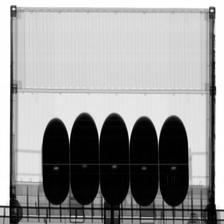

In [52]:
lista_pares[0][0]

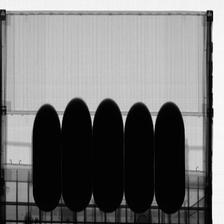

In [53]:
lista_pares[0][1]

# Models

In [72]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, \
    BatchNormalization, concatenate, Dense, Dropout, Flatten, Input, MaxPooling2D

nuclear_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    include_top=False) 
nuclear_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, None, None, 3 0           input_13[0][0]                   
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, None, None, 3 7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_4[0][0]            
_____________________________________________________________________________________

In [74]:
a_in = Input(shape=(*SIZE, 3))
b_in = Input(shape=(*SIZE, 3))

a_feat = nuclear_model(a_in)
b_feat = nuclear_model(b_in)

AttributeError: 'Tensor' object has no attribute 'output_shape'

In [75]:
combined_features = concatenate([a_feat, b_feat], name = 'merge_features')
combined_features = Flatten(name = 'flatten')(combined_features)
combined_features = Dense(16, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation = 'linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation = 'sigmoid')(combined_features)
similarity_model = tf.keras.Model(inputs = [a_in, b_in], outputs = [combined_features], name = 'Similarity_Model')
similarity_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0004),
                         loss = 'binary_crossentropy', metrics = ['mae'])
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
efficientnetb0 (Functional)     (None, None, None, 1 4049571     input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 7, 7, 2560)   0           efficientnetb0[2][

In [76]:
MODEL_DIR = '../models/transito'

epoch = 3
val_loss = 0.80

model_path = os.path.join(
    MODEL_DIR, 
    '04modelweights.{:02d}-{:.2f}.hdf5'.format(epoch, val_loss)
    )

if os.path.exists(model_path):
    similarity_model.load_weights(model_path)


In [77]:
def my_batch_generator(lista_pares, batch_size=8):
    lista_local = lista_pares.copy()
    while True:
        # Ciclar lista (se acabar, recarregar do começo)
        if len(lista_local) <= batch_size:
            lista_local = random.shuffle(lista_pares.copy())
        X1 = np.zeros((batch_size, *SIZE, 3))
        X2 = np.zeros((batch_size, *SIZE, 3))
        y = np.zeros((batch_size, 1))
        for ind in range(batch_size):
            batch = lista_local.pop()
            X1[ind, :, :, :] = np.array(batch[0]) / 255.
            if (ind % 2) == 0:
                X2[ind, :, :, :] = np.array(batch[1]) / 255.
                y[ind, :] = 0.01
            else:
                X2[ind, :, :, :] = np.array(lista_local[random.randint(0, len(lista_local) - 1)][1]) / 255.
                y[ind, :] = 0.99
        yield [X1, X2], y



In [78]:
batch_generator = my_batch_generator(lista_pares)
batch = next(batch_generator)
print(batch[0][1].shape, batch[0][1].shape, batch[1])

(8, 224, 224, 3) (8, 224, 224, 3) [[0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]
 [0.01]
 [0.99]]


In [79]:
print(len(lista_pares))

506


In [ ]:
similarity_model.fit(batch_generator,
                               steps_per_epoch=len(lista_pares) // 8,
                               epochs=100)


Epoch 1/100


2021-09-11 15:53:46.689494: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-09-11 15:53:49.189446: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7


52/63 [=======================>......] - ETA: 3s - loss: 0.8091 - mae: 0.4858